In [14]:
import pandas as pd
import numpy as np
from finlab.data import Data
from finlab import ml

data = Data()

rev = data.get("當月營收")
close = data.get("收盤價")
pe = data.get("本益比")
pb = data.get("股價淨值比")

### 計算features

In [15]:
import talib


def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def rsi(n):
    df = close.shift(-1) - close
    cond = (close.shift(-1) - close) >= 0
    rise = df[cond].fillna(0).rolling(n, min_periods=1).sum() / n
    fall = df[~cond].fillna(0).abs().rolling(n, min_periods=1).sum() / n
    rs = rise / fall

    return 100 * rs / (1+rs)

def mom_rev(n):
    return (rev / rev.shift(1)).shift(n)

def mom_pe(n):
    return (pe / pe.shift(1)).shift(n)

def mom_pb(n):
    return (pb / pb.shift(1)).shift(n)

features = {
    'mom_rev1': mom_rev(1),
    'mom_rev2': mom_rev(2),
    'mom_rev3': mom_rev(3),
    'mom_rev4': mom_rev(4),
    'mom_rev5': mom_rev(5),
    'mom_rev6': mom_rev(6),
    'mom_rev7': mom_rev(7),
    'mom_rev8': mom_rev(8),
    'mom_rev9': mom_rev(9),

    'mom_pe1': mom_pe(1),
    'mom_pe2': mom_pe(2),
    'mom_pe3': mom_pe(3),
    'mom_pe4': mom_pe(4),
    'mom_pe5': mom_pe(5),
    'mom_pe6': mom_pe(6),
    'mom_pe7': mom_pe(7),
    'mom_pe8': mom_pe(8),
    'mom_pe9': mom_pe(9),

    'mom_pb1': mom_pb(1),
    'mom_pb2': mom_pb(2),
    'mom_pb3': mom_pb(3),
    'mom_pb4': mom_pb(4),
    'mom_pb5': mom_pb(5),
    'mom_pb6': mom_pb(6),
    'mom_pb7': mom_pb(7),
    'mom_pb8': mom_pb(8),
    'mom_pb9': mom_pb(9),
    
    'bias5': bias(5),
    'bias10': bias(10),
    'bias20': bias(20),
    'bias60': bias(60),
    'bias90': bias(90),
    'bias120': bias(120),
    'bias240': bias(240),
    
    'acc5': acc(5),
    'acc10': acc(10),
    'acc20': acc(20),
    'acc60': acc(60),
    'acc90': acc(90),
    'acc120': acc(120),
    'acc240': acc(240),
    
    'rsi6': rsi(6),
    'rsi12': rsv(12),
    'rsi24': rsv(24)
}

### 製作dataset

#### 設定買賣頻率

In [16]:
every_month = rev.index
every_month

DatetimeIndex(['2005-02-10', '2005-03-10', '2005-04-10', '2005-05-10',
               '2005-06-10', '2005-07-10', '2005-08-10', '2005-09-10',
               '2005-10-10', '2005-11-10',
               ...
               '2019-10-10', '2019-11-10', '2019-12-10', '2020-01-10',
               '2020-02-10', '2020-03-10', '2020-04-10', '2020-05-10',
               '2020-06-10', '2020-07-10'],
              dtype='datetime64[ns]', name='date', length=186, freq=None)

### 將features整理後組裝起來

In [17]:
for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill').unstack()

In [18]:
dataset = pd.DataFrame(features)

In [19]:
feature_names = list(dataset.columns)

### 預處理

In [20]:
from finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

In [21]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset, feature_names=feature_names, thresh=0.01)

(363444, 46)


In [22]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [23]:
dataset_drop_extreme_case.index.get_level_values("date")

DatetimeIndex(['2005-02-10', '2005-03-10', '2005-04-10', '2005-05-10',
               '2005-06-10', '2005-07-10', '2005-08-10', '2005-09-10',
               '2005-10-10', '2005-11-10',
               ...
               '2019-08-10', '2019-09-10', '2019-10-10', '2019-11-10',
               '2019-12-10', '2020-01-10', '2020-02-10', '2020-03-10',
               '2020-05-10', '2020-06-10'],
              dtype='datetime64[ns]', name='date', length=291553, freq=None)

### 新增 label

In [24]:
dataset_train = dataset_dropna[:'2016']
dataset_test = dataset_dropna['2017':]

### 機器學習模型

#### 神經網路 (這裡沒有 accuracy 因為是在做 Regressor 而非 Classifier )

In [25]:
from keras.models import Sequential
from keras.initializers import he_normal
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = Sequential()
model.add(Dense(400, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=he_normal(seed=0)))

model.add(Dense(200, activation='relu',
                      kernel_initializer=he_normal(seed=0)))

model.add(Dense(100, activation='relu',
                      kernel_initializer=he_normal(seed=0)))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001))

_________________________________________________________________
Layer (type)                 Output Shape              Param #
dense_5 (Dense)              (None, 400)               18000
_________________________________________________________________
dense_6 (Dense)              (None, 200)               80200
_________________________________________________________________
dense_7 (Dense)              (None, 100)               20100
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101
Total params: 118,401
Trainable params: 118,401
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(dataset_train[feature_names], dataset_train['rank'],
                    batch_size=800,
                    epochs=200,
                    validation_split=0.15)

[..............................] - ETA: 0s - loss: 0.074 7200/46776 [===>..........................] - ETA: 0s - loss: 0.07114400/46776 [========>.....................] - ETA: 0s - loss: 0.07221600/46776 [============>.................] - ETA: 0s - loss: 0.07228800/46776 [=================>............] - ETA: 0s - loss: 0.07136000/46776 [======================>.......] - ETA: 0s - loss: 0.07143200/46776 [==========================>...] - ETA: 0s - loss: 0.07146776/46776 [==============================] - 0s 8us/step - loss: 0.0717 - val_loss: 0.0738
Epoch 168/200
  800/46776 [..............................] - ETA: 0s - loss: 0.073 8000/46776 [====>.........................] - ETA: 0s - loss: 0.07215200/46776 [========>.....................] - ETA: 0s - loss: 0.07122400/46776 [=============>................] - ETA: 0s - loss: 0.07129600/46776 [=================>............] - ETA: 0s - loss: 0.07136000/46776 [======================>.......] - ETA: 0s - loss: 0.07143200/46776 [========

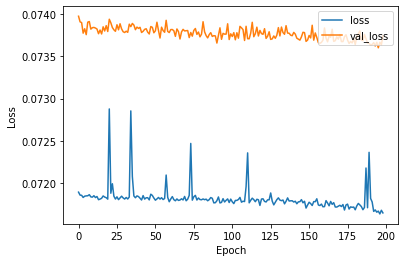

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'][1:], label='loss')
plt.plot(history.history['val_loss'][1:], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

#### lgb模型

In [28]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(n_estimators=500)
gbm.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

[44/44] features ████████████████████ Time elapsed: 13 seconds

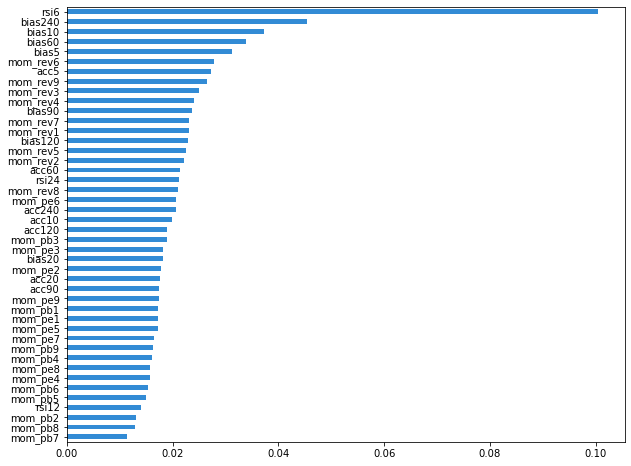

In [29]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(training_data=dataset_test[feature_names].values, 
                             feature_names=feature_names)
im_model = InMemoryModel(gbm.predict, examples=dataset_test[feature_names].values, 
                         target_names=['down', 'rise'])

plt.rcParams['figure.figsize'] = (10, 8)
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=False)

#### RF模型

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

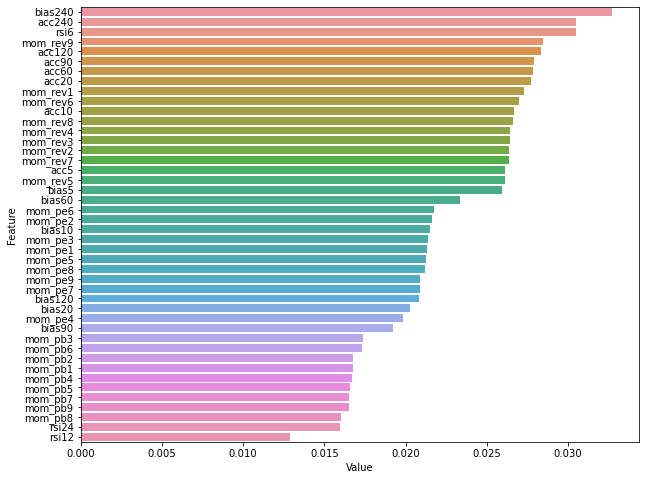

In [31]:
feature_imp = pd.DataFrame(zip(rf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)

import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 8)
sns.barplot(x="Value", y="Feature", data=feature_imp)

#### SVM模型

In [32]:
from sklearn.svm import SVR

svm = SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
        kernel='linear', max_iter=-1, shrinking=True,
        tol=0.001, verbose=False)

svm.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

[44/44] features ████████████████████ Time elapsed: 1617 seconds

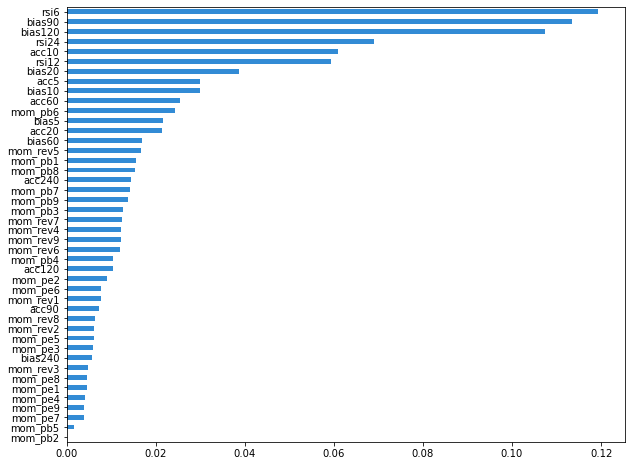

In [33]:
interpreter = Interpretation(training_data=dataset_test[feature_names].values, 
                             feature_names=feature_names)
im_model = InMemoryModel(svm.predict, examples=dataset_test[feature_names].values, 
                         target_names=['down', 'rise'])

plt.rcParams['figure.figsize'] = (10, 8)
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=False)

### Ensemble learning

In [34]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = gbm.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = rf.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

vals = svm.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result4'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")

# backtest

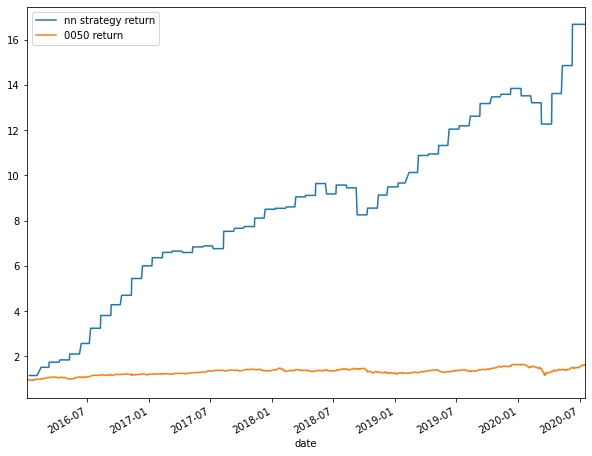

In [35]:
import math


dates = sorted(list(set(dataset_drop.index)))

rs = []
for d in dates:
    
    dataset_time = dataset_drop.loc[d]
    
    dataset_time = drop_extreme_case(dataset_time, feature_names, thresh=0.01)
    
    rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] + dataset_time['result4'] 
    
    condition = (rank >= rank.nlargest(20).iloc[-1]) 
    r = dataset_time['return'][condition].mean()

    rs.append(r * (1-3/1000-1.425/1000*2*0.6))

rs = pd.Series(rs, index=dates)['2016':].cumprod()

s0050 = close['0050']['2016':]

pd.DataFrame({'Ensemble strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()